# Import packages & functions

In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import copy
import math
import time
import random
import webdataset as wds
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn as nn
from torchvision import transforms
import utils
from models import *

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True # fixes Conv3D

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
if num_devices is None: 
    num_devices = 1
else:
    num_devices = int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
if node is None:
    node = 0
else:
    node = int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
if global_rank is None:
    global_rank = 0
else:
    global_rank = int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
if world_size is None: 
    world_size = 1
else:
    world_size = int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in models.py or utils.py and 
    # have this notebook automatically update with your revisions
    %load_ext autoreload
    %autoreload 2
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)

# create global variables from the config
print("\n__CONFIG__")
for attribute_name in config.keys():
    print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

data_type = torch.float32 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    import torch.multiprocessing as mp
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    dist.init_process_group("nccl", rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier()
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__CONFIG__
model_name = brain_textfrozen_brainckpt_loss1
data_path = /weka/proj-fmri/shared/mindeyev2_dataset
cache_dir = /weka/proj-fmri/shared/cache
batch_size = 128
wandb_log = True
ckpt_interval = 10
ckpt_saving = False
seed = 0
hidden_dim = 768
seq_len = 1
max_lr = 3e-05
num_epochs = 50
num_test_iterations_per_epoch = 30
use_brain = True
temperature = 0.006


PID of this process = 1546942
device = cuda distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [2]:
def my_split_by_node(urls): return urls
num_voxels_list = []
subj_list = np.arange(1,9)

# remove subj
subj = 1
subj_list = subj_list[subj_list != subj]
print("subj_list", subj_list)

nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
num_samples_per_epoch = (750*40) // num_devices 

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

subj_list [2 3 4 5 6 7 8]
dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 18 num_iterations_per_epoch = 238 num_samples_per_epoch = 30000


In [3]:
train_data = {}
train_dl = {}
num_voxels = {}
voxels = {}
for s in subj_list:
    train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{nsessions_allsubj[s-1]-1}" + "}.tar"
    print(train_url)
    
    train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=1500, rng=random.Random(42))\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    train_dl[f'subj0{s}'] = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

    # Load hdf5 data for betas, but don't put everything into memory
    f = h5py.File(f'{data_path}/betas_all_subj0{s}_fp32_renorm.hdf5', 'r')
    
    betas = f['betas'][:]
    betas = torch.Tensor(betas).to("cpu").to(data_type)
    num_voxels_list.append(betas[0].shape[-1])
    num_voxels[f'subj0{s}'] = betas[0].shape[-1]
    voxels[f'subj0{s}'] = betas
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and betas!\n")

# Validate only on one subject
subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
# if subj==3:
#     num_test=2371
# elif subj==4:
#     num_test=2188
# elif subj==6:
#     num_test=2371
# elif subj==8:
#     num_test=2188
# else:
#     num_test=3000
test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
print(test_url)
test_data = wds.WebDataset(test_url,resampled=True,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj02/train/{0..39}.tar
num_voxels for subj02: 14278
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj03/train/{0..31}.tar
num_voxels for subj03: 15226
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj04/train/{0..29}.tar
num_voxels for subj04: 13153
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj05/train/{0..39}.tar
num_voxels for subj05: 13039
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj06/train/{0..31}.tar
num_voxels for subj06: 17907
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj07/train/{0..39}.tar
num_voxels for subj07: 12682
/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj08/train/{0..29}.tar
num_voxels for subj08: 14386
Loaded all subj train dls and betas!

/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj02/new_test/0.tar
Loaded test dl for subj2!



In [4]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)

Loaded all 73k possible NSD images to cpu! torch.Size([73000, 3, 224, 224])


In [5]:
annots = np.load(f'{data_path}/COCO_73k_annots_curated.npy')

def embed_curated_annotations(annots,random=True):
    for i,b in enumerate(annots):
        t = ''
        j = -1
        while t == '':
            if random:
                rand = torch.randint(5,(1,1))[0][0]
                t = b[rand]
            else:
                j += 1
                t = b[j]
        if i==0:
            txt = np.array(t)
        else:
            txt = np.hstack((txt,t))
    return txt
    
embed_curated_annotations(annots[:2],random=False)

array(["A person kitesurfing over the waves of the ocean's shore.",
       'A cat sitting on the edge of the toilet looking toward the open bathroom door.'],
      dtype='<U78')

## Load models

In [6]:
class BaseModule(nn.Module):
    def __init__(self):
        super(BaseModule, self).__init__()
    def forward(self, x):
        return x
model = BaseModule()
model

BaseModule()

In [7]:
import clip # so we can use the clip tokenizer
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])
clip_seq_dim = 1
clip_emb_dim = 768

In [8]:
class SimpleViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, num_classes=768, dim=768, depth=12, heads=12, mlp_dim=3072, channels=3, dropout=0.1, emb_dropout=0.1):
        super(SimpleViT, self).__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.to_patch_embedding = nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout),
            num_layers=depth
        )

        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)  # (batch_size, dim, num_patches ** 0.5, num_patches ** 0.5)
        x = x.flatten(2)  # (batch_size, dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, dim)
        b, n, _ = x.shape

        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, dim)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch_size, dim)
        x = self.transformer(x)
        x = x[0]  # Take the CLS token output
        return self.mlp_head(x)
    
model.image = SimpleViT()
utils.count_params(model.image)
utils.count_params(model)

# test on subject 1 with fake data
b = preprocess(images[:2])
print(b.shape, model.image(b).shape)

/admin/home-paulscotti/mindeye/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


param counts:
86,389,248 total
86,389,248 trainable
param counts:
86,389,248 total
86,389,248 trainable
torch.Size([2, 3, 224, 224]) torch.Size([2, 768])


In [9]:
# class SimpleTextTransformer(nn.Module):
#     def __init__(self, vocab_size=49408, d_model=768, nhead=12, num_layers=6, dim_feedforward=2048, dropout=0.1):
#         super(SimpleTextTransformer, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, d_model)
#         self.positional_encoding = nn.Parameter(torch.randn(1, 77, d_model))  # Assuming max token length of 77
#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
#             num_layers=num_layers
#         )
#         self.fc_out = nn.Linear(d_model, 768)

#     def forward(self, src):
#         # src shape: (batch_size, seq_len)
#         src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
#         # Transformer expects (seq_len, batch_size, dim)
#         src = src.permute(1, 0, 2)
#         src = self.transformer(src)
#         # Permute back to (batch_size, seq_len, dim)
#         src = src.permute(1, 0, 2)
#         # Use mean pooling over the sequence length for simplicity
#         src = src.mean(dim=1)
#         return self.fc_out(src)
    
# model.text = SimpleTextTransformer()
# utils.count_params(model.text)
# utils.count_params(model)

# # test on subject 1 with fake data
# b = clip.tokenize(embed_curated_annotations(annots[:2]))
# print(b.shape, model.text(b).shape)

clip_model, _ = clip.load("ViT-L/14", device=device)
# clip_model.encode_text(text)

In [10]:
if use_brain:
    class RidgeRegression(torch.nn.Module):
        # make sure to add weight_decay when initializing optimizer
        def __init__(self, input_sizes, out_features, final_out, seq_len): 
            super(RidgeRegression, self).__init__()
            self.out_features = out_features
            self.linears = torch.nn.ModuleList([
                    torch.nn.Linear(input_size, out_features) for input_size in input_sizes
                ])
            self.projector = nn.Sequential(
                nn.LayerNorm(out_features),
                nn.GELU(),
                nn.Linear(out_features, out_features),
                nn.LayerNorm(out_features),
                nn.GELU(),
                nn.Linear(out_features, final_out),
                nn.LayerNorm(final_out),
                nn.GELU(),
                nn.Linear(final_out, final_out)
            )
        def forward(self, x, subj_idx=0):
            out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
            out = self.projector(out).squeeze(1)
            return out

    model.ridge = RidgeRegression(num_voxels_list, out_features=1024, final_out=hidden_dim, seq_len=seq_len)
    utils.count_params(model.ridge)
    utils.count_params(model)

    # test on subject 1 with fake data
    b = torch.randn((2,seq_len,num_voxels_list[0]))
    print(b.shape, model.ridge(b,0).shape)

param counts:
105,527,296 total
105,527,296 trainable
param counts:
191,916,544 total
191,916,544 trainable
torch.Size([2, 1, 14278]) torch.Size([2, 768])


In [11]:
if use_brain:
    ckpt_path = "/weka/proj-fmri/paulscotti/MindEyeV2/train_logs/multisubject_subj01_1024hid/last.pth"
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    model.load_state_dict(state_dict, strict=False)
    print("ckpt loaded!")
    
    # disable further training of the linears
    model.ridge.linears.requires_grad_(False)

[2024-05-20 17:22:48,704] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
ckpt loaded!


### Setup optimizer / lr / ckpt saving

In [12]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
print("total_steps", total_steps)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    total_steps=total_steps,
    final_div_factor=1000,
    last_epoch=-1, pct_start=2/num_epochs
)

outdir = os.path.abspath(f'../ckpts/{model_name}')
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    os.makedirs(outdir,exist_ok=True)
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 11900

Done with model preparations!
param counts:
191,916,544 total
88,822,272 trainable


# Weights and Biases

In [13]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'neuroclip'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_params": num_params,
      "max_lr": max_lr,
      "num_samples_per_epoch": num_samples_per_epoch,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

wandb neuroclip run brain_textfrozen_brainckpt_loss1
wandb_config:
 {'model_name': 'brain_textfrozen_brainckpt_loss1', 'global_batch_size': 128, 'batch_size': 18, 'num_epochs': 50, 'num_params': 88822272, 'max_lr': 3e-05, 'num_samples_per_epoch': 30000, 'ckpt_interval': 10, 'ckpt_saving': False, 'seed': 0, 'distributed': False, 'num_devices': 1, 'world_size': 1, 'train_url': '/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj08/train/{0..29}.tar', 'test_url': '/weka/proj-fmri/shared/mindeyev2_dataset/wds/subj02/new_test/0.tar'}
wandb_id: brain_textfrozen_brainckpt_loss1


wandb: Currently logged in as: paul-scotti. Use `wandb login --relogin` to force relogin


# Main

In [14]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()
model.to(device)

BaseModule(
  (image): SimpleViT(
    (to_patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (to_cls_token): Identity()
    (mlp_head): Sequential(
      (0): LayerNorm((768,), eps=1e-0

In [15]:
train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

In [16]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
crossentropy = nn.CrossEntropyLoss()
mixup_pct = 0.
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

for epoch in progress_bar:
    model.train()

    ret_percent_correct = 0.
    test_ret_percent_correct = 0.
    
    txt_2_img_percent_correct = 0.
    test_txt_2_img_percent_correct = 0.
    
    img_2_txt_percent_correct = 0.
    test_img_2_txt_percent_correct = 0.

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    annot_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 77).long()
    perm_iters, betas_iters, select_iters = {}, {}, {}
    for s, train_dl in enumerate(train_dls):
        with torch.cuda.amp.autocast(dtype=data_type):
            for iter, (behav0, past_behav0, future_behav0, old_behav0) in enumerate(train_dl):    
                image0 = images[behav0[:,0,0].cpu().long()].float()
                image_iters[iter,s*batch_size:s*batch_size+batch_size] = image0
                
                text0 = embed_curated_annotations(annots[behav0[:,0,0].cpu().long().numpy()])
                annot_iters[iter,s*batch_size:s*batch_size+batch_size] = clip.tokenize(text0)
                
                voxel0 = voxels[f'subj0{subj_list[s]}'][behav0[:,0,5].cpu().long()]
                voxel0 = torch.Tensor(voxel0)
                
                # seq_len=1
                voxel0 = voxel0.unsqueeze(1)

                voxel_iters[f"subj0{subj_list[s]}_iter{iter}"] = voxel0

                if iter >= num_iterations_per_epoch-1:
                    break

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i in range(num_iterations_per_epoch):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()

            voxel_list = [voxel_iters[f"subj0{s}_iter{train_i}"].detach().to(device) for s in subj_list]
            image = image_iters[train_i].detach()
            image = image.to(device)
            annot = annot_iters[train_i].detach()
            annot = annot.to(device)

            clip_image = model.image(image)
            clip_text = clip_model.encode_text(annot) #model.text(annot)

            if use_brain:
                voxel_ridge_list = [model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
                clip_brain = torch.cat(voxel_ridge_list, dim=0)
            
            labels = torch.arange(len(clip_image)).to(device)
            
            clip_image = nn.functional.normalize(clip_image, dim=-1)
            clip_text = nn.functional.normalize(clip_text, dim=-1)
            if use_brain:
                clip_brain = nn.functional.normalize(clip_brain, dim=-1)

#             # Calculate logits for each pair of modalities
#             logits_image_text = (clip_image @ clip_text.T) / temperature
#             logits_text_image = logits_image_text.T

#             if use_brain:
#                 logits_image_brain = (clip_image @ clip_brain.T) / temperature
#                 logits_brain_image = logits_image_brain.T

#                 logits_text_brain = (clip_text @ clip_brain.T) / temperature
#                 logits_brain_text = logits_text_brain.T

#             # Calculate cross-entropy loss for each pair of modalities
#             loss_image_text = nn.functional.cross_entropy(logits_image_text, labels)
#             loss_text_image = nn.functional.cross_entropy(logits_text_image, labels)

#             if use_brain:
#                 loss_image_brain = nn.functional.cross_entropy(logits_image_brain, labels)
#                 loss_brain_image = nn.functional.cross_entropy(logits_brain_image, labels)

#                 loss_text_brain = nn.functional.cross_entropy(logits_text_brain, labels)
#                 loss_brain_text = nn.functional.cross_entropy(logits_brain_text, labels)

#             # Calculate the average loss
#             if use_brain:
#                 loss = (loss_image_text + loss_text_image + loss_image_brain + loss_brain_image + loss_text_brain + loss_brain_text) / 6
#             else:
#                 loss = (loss_image_text + loss_text_image) / 2

#             # gradient clipping (set to 1.0) to improve stability
#             nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            loss1 = crossentropy(clip_image, clip_text)
            loss2 = crossentropy(clip_image, clip_brain)
            loss3 = crossentropy(clip_text, clip_brain)
            # loss = (loss1 + loss2 + loss3) / 3
            # loss = (loss1 + loss2) / 2
            loss = loss1
            
            ret1 = utils.topk(utils.batchwise_cosine_similarity(clip_image, clip_text), labels, k=1).item()
            ret2 = utils.topk(utils.batchwise_cosine_similarity(clip_text, clip_image), labels, k=1).item()

            if use_brain:
                ret3 = utils.topk(utils.batchwise_cosine_similarity(clip_image, clip_brain), labels, k=1).item()
                ret4 = utils.topk(utils.batchwise_cosine_similarity(clip_brain, clip_image), labels, k=1).item()

                ret5 = utils.topk(utils.batchwise_cosine_similarity(clip_text, clip_brain), labels, k=1).item()
                ret6 = utils.topk(utils.batchwise_cosine_similarity(clip_brain, clip_text), labels, k=1).item()
                
            if use_brain:
                ret_percent_correct += (ret1 + ret2 + ret3 + ret4 + ret5 + ret6) / 6
            else:
                ret_percent_correct += (ret1 + ret2) / 2
                
            img_2_txt_percent_correct += ret1
            txt_2_img_percent_correct += ret2

            utils.check_loss(loss)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav0, past_behav0, future_behav0, old_behav0) in enumerate(test_dl):  
                image = images[behav0[:,0,0].cpu().long()].float()
                annot = embed_curated_annotations(annots[behav0[:,0,0].cpu().long().numpy()])
                annot = clip.tokenize(annot)
                voxel = voxels[f'subj0{subj}'][behav0[:,0,5].cpu().long()]
                voxel = torch.Tensor(voxel)
                voxel = voxel.unsqueeze(1)
                
                image = image.to(device)
                annot = annot.to(device)
                voxel = voxel.to(device)
                
                clip_image = model.image(image)
                clip_text = clip_model.encode_text(annot) #model.text(annot)
                if use_brain:
                    clip_brain = model.ridge(voxel,0)
                
                labels = torch.arange(len(clip_image)).to(device)

                clip_image = nn.functional.normalize(clip_image, dim=-1)
                clip_text = nn.functional.normalize(clip_text, dim=-1)
                if use_brain:
                    clip_brain = nn.functional.normalize(clip_brain, dim=-1)

#                 # Calculate logits for each pair of modalities
#                 logits_image_text = (clip_image @ clip_text.T) / temperature
#                 logits_text_image = logits_image_text.T

#                 if use_brain:
#                     logits_image_brain = (clip_image @ clip_brain.T) / temperature
#                     logits_brain_image = logits_image_brain.T

#                     logits_text_brain = (clip_text @ clip_brain.T) / temperature
#                     logits_brain_text = logits_text_brain.T

#                 # Calculate cross-entropy loss for each pair of modalities
#                 loss_image_text = nn.functional.cross_entropy(logits_image_text, labels)
#                 loss_text_image = nn.functional.cross_entropy(logits_text_image, labels)

#                 if use_brain:
#                     loss_image_brain = nn.functional.cross_entropy(logits_image_brain, labels)
#                     loss_brain_image = nn.functional.cross_entropy(logits_brain_image, labels)

#                     loss_text_brain = nn.functional.cross_entropy(logits_text_brain, labels)
#                     loss_brain_text = nn.functional.cross_entropy(logits_brain_text, labels)

#                 # Calculate the average loss
#                 if use_brain:
#                     loss = (loss_image_text + loss_text_image + loss_image_brain + loss_brain_image + loss_text_brain + loss_brain_text) / 6
#                 else:
#                     loss = (loss_image_text + loss_text_image) / 2

                loss1 = crossentropy(clip_image, clip_text)
                loss2 = crossentropy(clip_image, clip_brain)
                loss3 = crossentropy(clip_text, clip_brain)
                # loss = (loss1 + loss2 + loss3) / 3
                # loss = (loss1 + loss2) / 2
                loss = loss1
                
                ret1 = utils.topk(utils.batchwise_cosine_similarity(clip_image, clip_text), labels, k=1).item()
                ret2 = utils.topk(utils.batchwise_cosine_similarity(clip_text, clip_image), labels, k=1).item()

                if use_brain:
                    ret3 = utils.topk(utils.batchwise_cosine_similarity(clip_image, clip_brain), labels, k=1).item()
                    ret4 = utils.topk(utils.batchwise_cosine_similarity(clip_brain, clip_image), labels, k=1).item()

                    ret5 = utils.topk(utils.batchwise_cosine_similarity(clip_text, clip_brain), labels, k=1).item()
                    ret6 = utils.topk(utils.batchwise_cosine_similarity(clip_brain, clip_text), labels, k=1).item()

                if use_brain:
                    test_ret_percent_correct += (ret1 + ret2 + ret3 + ret4 + ret5 + ret6) / 6
                else:
                    test_ret_percent_correct += (ret1 + ret2) / 2
                    
                test_img_2_txt_percent_correct += ret1
                test_txt_2_img_percent_correct += ret2
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())
                
                if test_i >= num_test_iterations_per_epoch-1:
                    break

            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/ret_pct_correct": ret_percent_correct / (train_i + 1),
                "test/test_ret_pct_correct": test_ret_percent_correct / (test_i + 1),
                "train/img_2_txt_percent_correct": img_2_txt_percent_correct / (train_i + 1),
                "test/img_2_txt_percent_correct": test_img_2_txt_percent_correct / (test_i + 1),
                "train/txt_2_img_percent_correct": txt_2_img_percent_correct / (train_i + 1),
                "test/txt_2_img_percent_correct": test_txt_2_img_percent_correct / (test_i + 1),
                }
            progress_bar.set_postfix(**logs)
            
            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0): save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    if distributed: dist.barrier()

print("\n===Finished!===\n")
if ckpt_saving: save_ckpt(f'last')

brain_textfrozen_brainckpt_loss1 starting with epoch 0 / 50


  0%|                                                                                                         …


===Finished!===



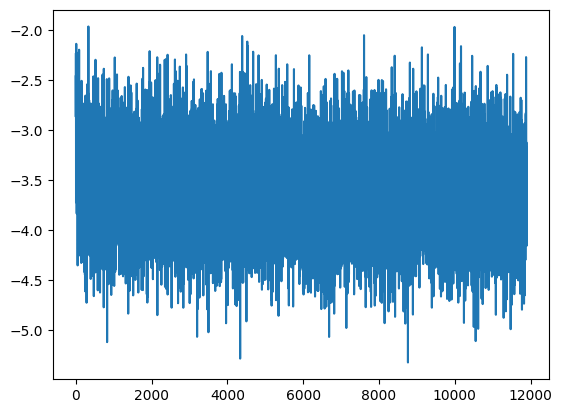

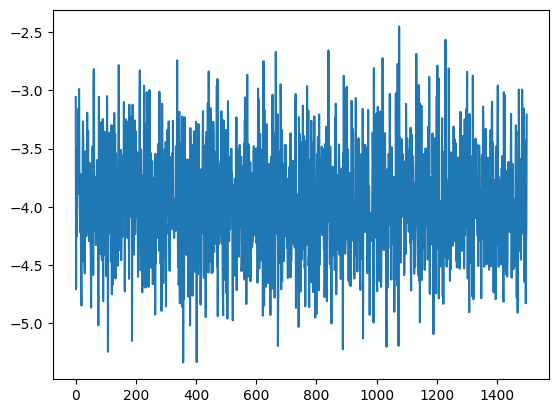

In [17]:
# use_brain=True | 10/10 [17:00<00:00, 102.90s/it, test/loss=3.07, test/num_steps=40, test/test_ret_pct_correct=0.187, test/txt_2_img_percent_correct=0.155, train/loss=1.83, train/lr=1.2e-9, train/num_steps=9370, train/ret_pct_correct=0.433, train/txt_2_img_percent_correct=0.295]
# use_brain=False | 10/10 [14:41<00:00, 87.83s/it, test/loss=3.39, test/num_steps=40, test/test_ret_pct_correct=0.155, test/txt_2_img_percent_correct=0.16, train/loss=2.33, train/lr=1.2e-9, train/num_steps=9370, train/ret_pct_correct=0.294, train/txt_2_img_percent_correct=0.297]
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()